In [29]:
library("bvartools")
library("vars")
library("urca")
library("tsDyn")
library("aod")
library("tseries")

# Cointegration Modelling (VAR + VECM) incl. Toda Yamamoto procedure

## Data Load and Description

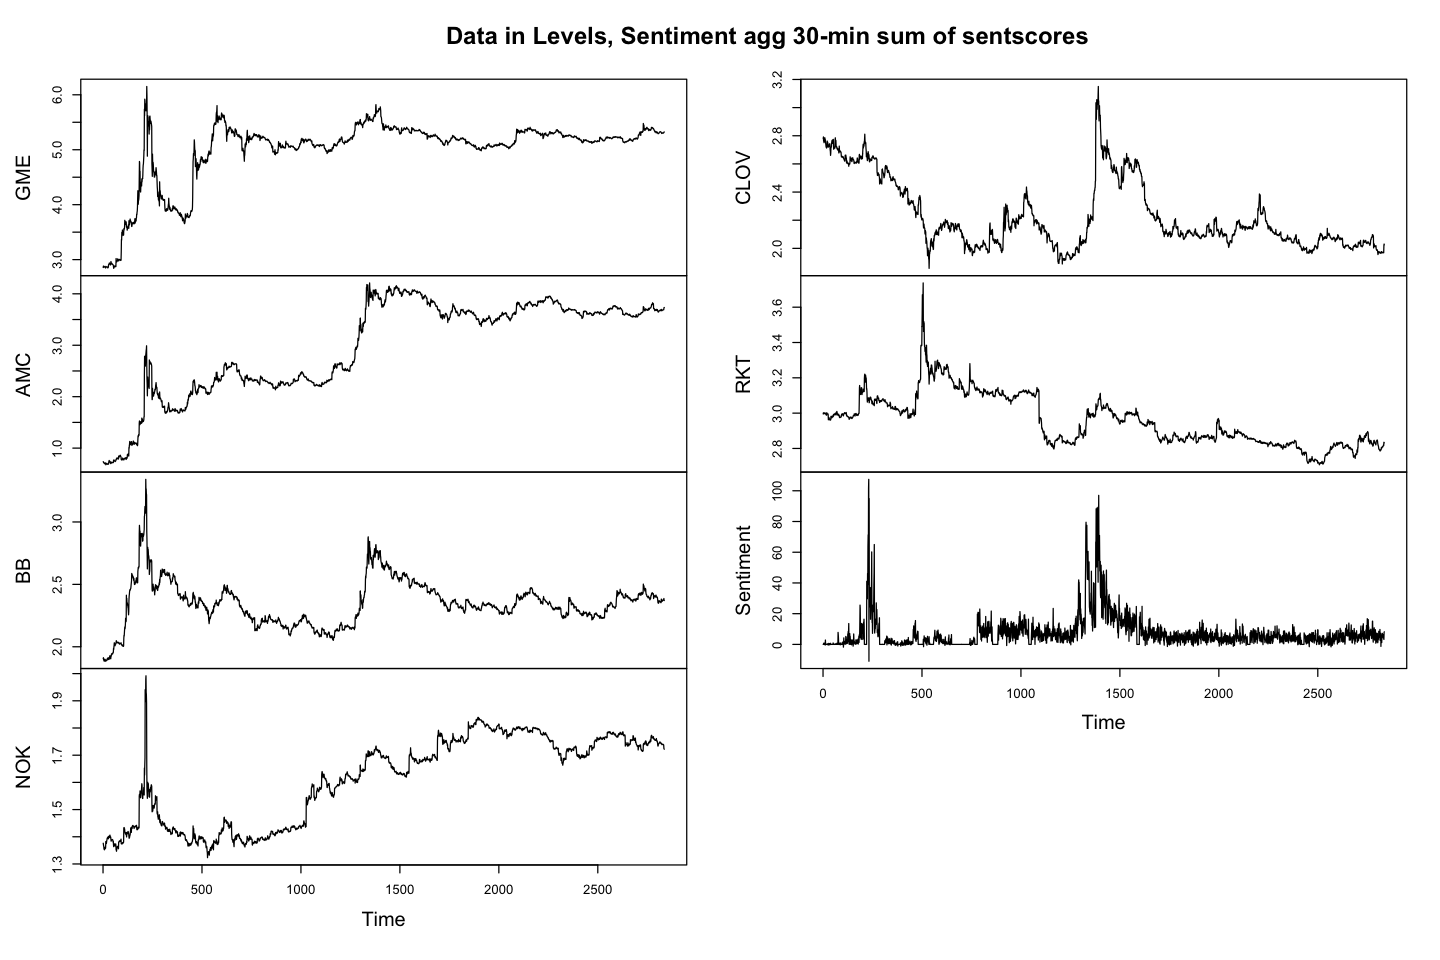

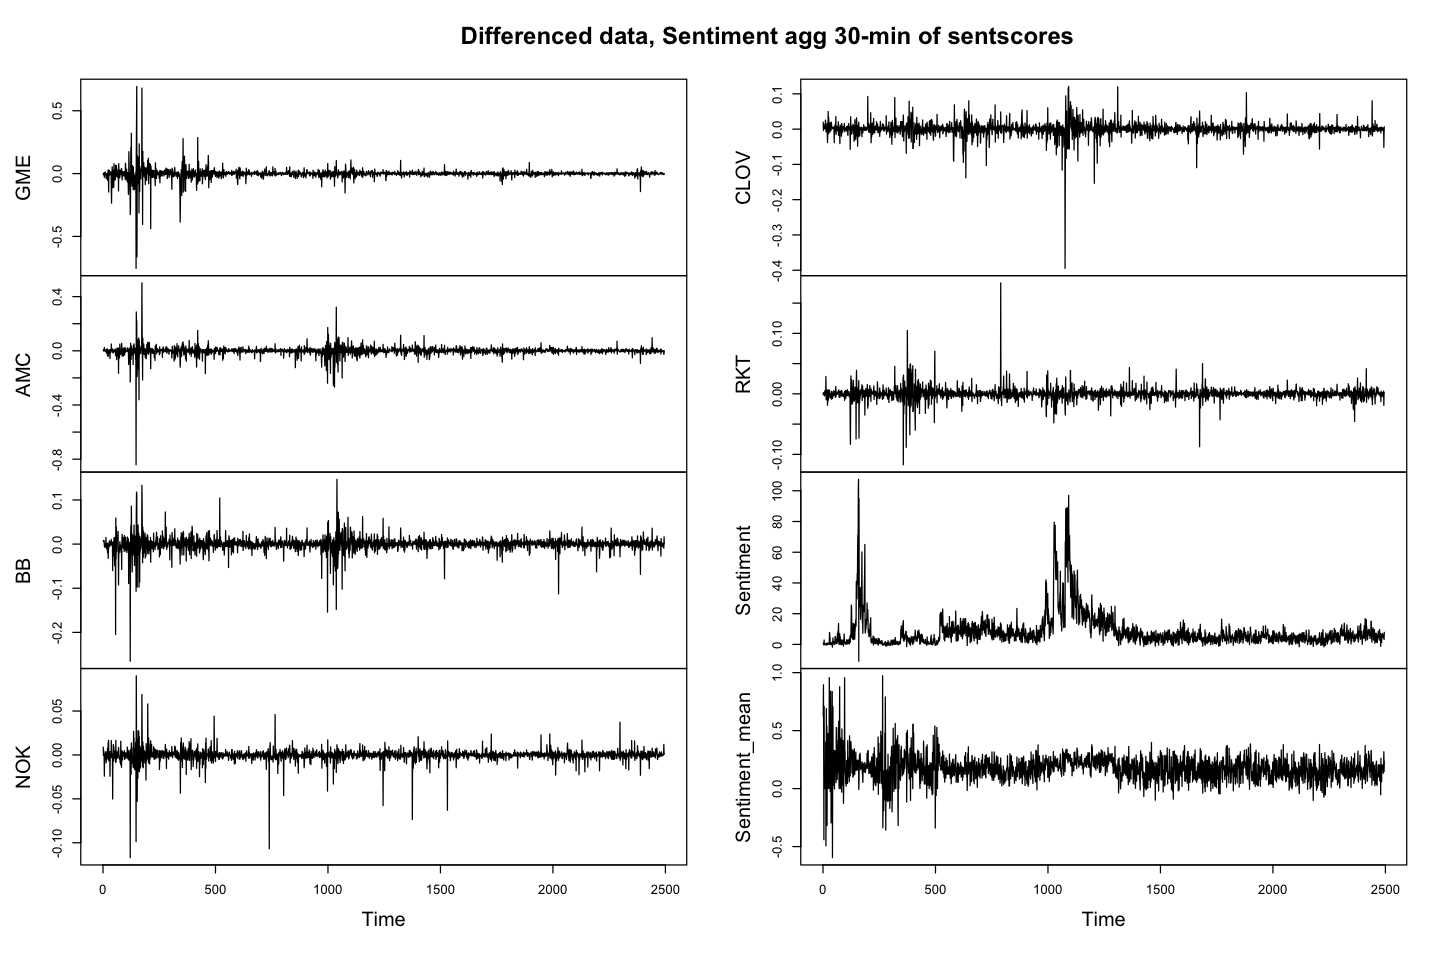

In [2]:
options(repr.plot.width = 12, repr.plot.height = 8)
coint_data <- read.csv.zoo("coint_data.csv")
data_level <- read.csv("coint_data_raw.csv")
#Sentiment is 30-min aggregated sum of sentiment scores (reflects intensity)
#Sentiment_mean is 30-min aggregated mean sentiment score
plot.ts(data_level[-1], main = "Data in Levels, Sentiment agg 30-min sum of sentscores")
plot.ts(data.frame(coint_data[-1]), main = "Differenced data, Sentiment agg 30-min of sentscores")

## Stationarity Tests
ADF identifies all logarithmic stock price series as unit roots (i.e. null hypothesis of unit root is not rejected). After including trend (+ intercept) the logarithmic series are now stationary (p-values < $1\%$). 

However, the aggregated sum of sentiment scores sampled on a 30-min frequency according to ADF test is stationary even after including trend and intercept.

In [3]:
for (i in colnames(data_level[-1])){
    print(sprintf("ADF test for %s p-value: %.4f", i,
                  ur.df(data_level[, i], selectlags = "BIC")@testreg$coef[1,4]))
    print(sprintf("ADF test incl. trend for %s p-value: %.4f", i,
                  ur.df(data_level[, i], type = "trend", selectlags = "BIC")@testreg$coef[1,4]))
#     print(summary(ur.df(data_level[, i], type = "trend", selectlags = "BIC")))
    cat("\n")
}

[1] "ADF test for GME p-value: 0.5268"
[1] "ADF test incl. trend for GME p-value: 0.0002"

[1] "ADF test for AMC p-value: 0.4832"
[1] "ADF test incl. trend for AMC p-value: 0.0033"

[1] "ADF test for BB p-value: 0.8378"
[1] "ADF test incl. trend for BB p-value: 0.0006"

[1] "ADF test for NOK p-value: 0.6779"
[1] "ADF test incl. trend for NOK p-value: 0.0007"

[1] "ADF test for CLOV p-value: 0.3096"
[1] "ADF test incl. trend for CLOV p-value: 0.0070"

[1] "ADF test for RKT p-value: 0.7093"
[1] "ADF test incl. trend for RKT p-value: 0.0005"

[1] "ADF test for Sentiment p-value: 0.0000"
[1] "ADF test incl. trend for Sentiment p-value: 0.0004"



### KPSS Tests
KPSS tests results show strong evidence for rejecting stationarity for all relevant series. Notably, sentiment for which unit root was rejected as per ADF test, according to KPSS test is non-stationary. Therefore, we can conclude while the sentiment series is not unit root it is close enough. We further proceed with the unchanged sentiment series and assume it is $I(1)$.

In [4]:
for (i in colnames(data_level[-1])){
    kpss = suppressWarnings(kpss.test(data_level[, i], null = "Trend", lshort = FALSE ))
    print(sprintf("KPSS test statistic for %s: %.4f", i,
                  kpss$statistic))
    print(sprintf("p-value (may be smaller): %.4f",
                  kpss$p.value))
#     print(summary(ur.kpss(data_level[, i], type = "tau", use.lag = 12)))
    cat("\n")
}

[1] "KPSS test statistic for GME: 1.1275"
[1] "p-value (may be smaller): 0.0100"

[1] "KPSS test statistic for AMC: 1.2800"
[1] "p-value (may be smaller): 0.0100"

[1] "KPSS test statistic for BB: 0.2569"
[1] "p-value (may be smaller): 0.0100"

[1] "KPSS test statistic for NOK: 0.9651"
[1] "p-value (may be smaller): 0.0100"

[1] "KPSS test statistic for CLOV: 0.5596"
[1] "p-value (may be smaller): 0.0100"

[1] "KPSS test statistic for RKT: 0.4237"
[1] "p-value (may be smaller): 0.0100"

[1] "KPSS test statistic for Sentiment: 0.5677"
[1] "p-value (may be smaller): 0.0100"



### Check stationarity after differencing (integration degree)

Are series are shown I(1) (we assume same for sentiment series as discussed above). Null hypothesis of unit root is rejected for all series after first differencing.

KPSS test after differencing sentiment series cannot reject stationarity.

In [5]:
for (i in colnames(data_level[-1])){
    adf = ur.df(diff(data_level[, i]), selectlags = "BIC")
    print("##############################################################################")
    print(sprintf("Augmented Dickey-Fuller Test Unit Root test for %s p-value: %.4f", i,
                  adf@testreg$coef[1,4]))
    adf = ur.df(diff(data_level[, i]), type = "drift", selectlags = "BIC")
    print(sprintf("incl. drift for %s p-value: %.4f", i,
                  adf@testreg$coef[1,4]))
#     print(summary(ur.df(data_level[, i], type = "trend", selectlags = "BIC")))
    cat("\n")
}
print("KPSS test for GME")
ur.kpss(diff(data_level$Sentiment))

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for GME p-value: 0.0000"
[1] "incl. drift for GME p-value: 0.2847"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for AMC p-value: 0.0000"
[1] "incl. drift for AMC p-value: 0.1535"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for BB p-value: 0.0000"
[1] "incl. drift for BB p-value: 0.6472"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for NOK p-value: 0.0000"
[1] "incl. drift for NOK p-value: 0.5442"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for CLOV p-value: 0.0000"
[1] "incl. drift for CLOV p-value:


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0054 


---
# Toda Yamamoto Procedure
## VAR Model (in levels): Selecting optimal lag
For parsimony choise of optimal lag is based on BC/SC criteria.
Among VAR specifications including up to 12 lags, modification with 2 lags is chosen. Other criteria imply overspecified models with the maximum amount of possible lags (amongst tested specifications)

In [6]:
##Reorder dataframe
data <- data_level[c("X","Sentiment","GME","AMC","BB","NOK","CLOV","RKT")]
# data <- data_level[c("X","GME","Sentiment","AMC","BB","NOK","CLOV","RKT")]
varselect <- VARselect(data[-1], lag = 12, type = "both")
p <- as.numeric(varselect$selection[3]) #optimal number of lags
print(sprintf("Optimal VAR specification with %d lags is chosen", p))
cat("#################################################################################################")
var_optim <- VAR(data[-1], p = p, type = "both")
summary(var_optim)

[1] "Optimal VAR specification with 2 lags is chosen"
#################################################################################################


VAR Estimation Results:
Endogenous variables: Sentiment, GME, AMC, BB, NOK, CLOV, RKT 
Deterministic variables: both 
Sample size: 2834 
Log Likelihood: 35030.096 
Roots of the characteristic polynomial:
0.9957 0.995 0.991 0.991 0.9896 0.9762 0.8744 0.3794 0.1296 0.1159 0.08035 0.03861 0.03861 0.03088
Call:
VAR(y = data[-1], p = p, type = "both")


Estimation results for equation Sentiment: 
Sentiment = Sentiment.l1 + GME.l1 + AMC.l1 + BB.l1 + NOK.l1 + CLOV.l1 + RKT.l1 + Sentiment.l2 + GME.l2 + AMC.l2 + BB.l2 + NOK.l2 + CLOV.l2 + RKT.l2 + const + trend 

               Estimate Std. Error t value Pr(>|t|)    
Sentiment.l1  4.805e-01  1.791e-02  26.821  < 2e-16 ***
GME.l1        4.405e+00  2.795e+00   1.576 0.115131    
AMC.l1       -6.947e+00  3.692e+00  -1.881 0.060011 .  
BB.l1        -9.570e+00  6.874e+00  -1.392 0.163992    
NOK.l1       -2.149e+00  1.131e+01  -0.190 0.849406    
CLOV.l1       2.028e+01  5.543e+00   3.659 0.000258 ***
RKT.l1       -3.745e+00  8.150e+00  -0.459 0.6

[1] 1.004282
[1] 1.005049


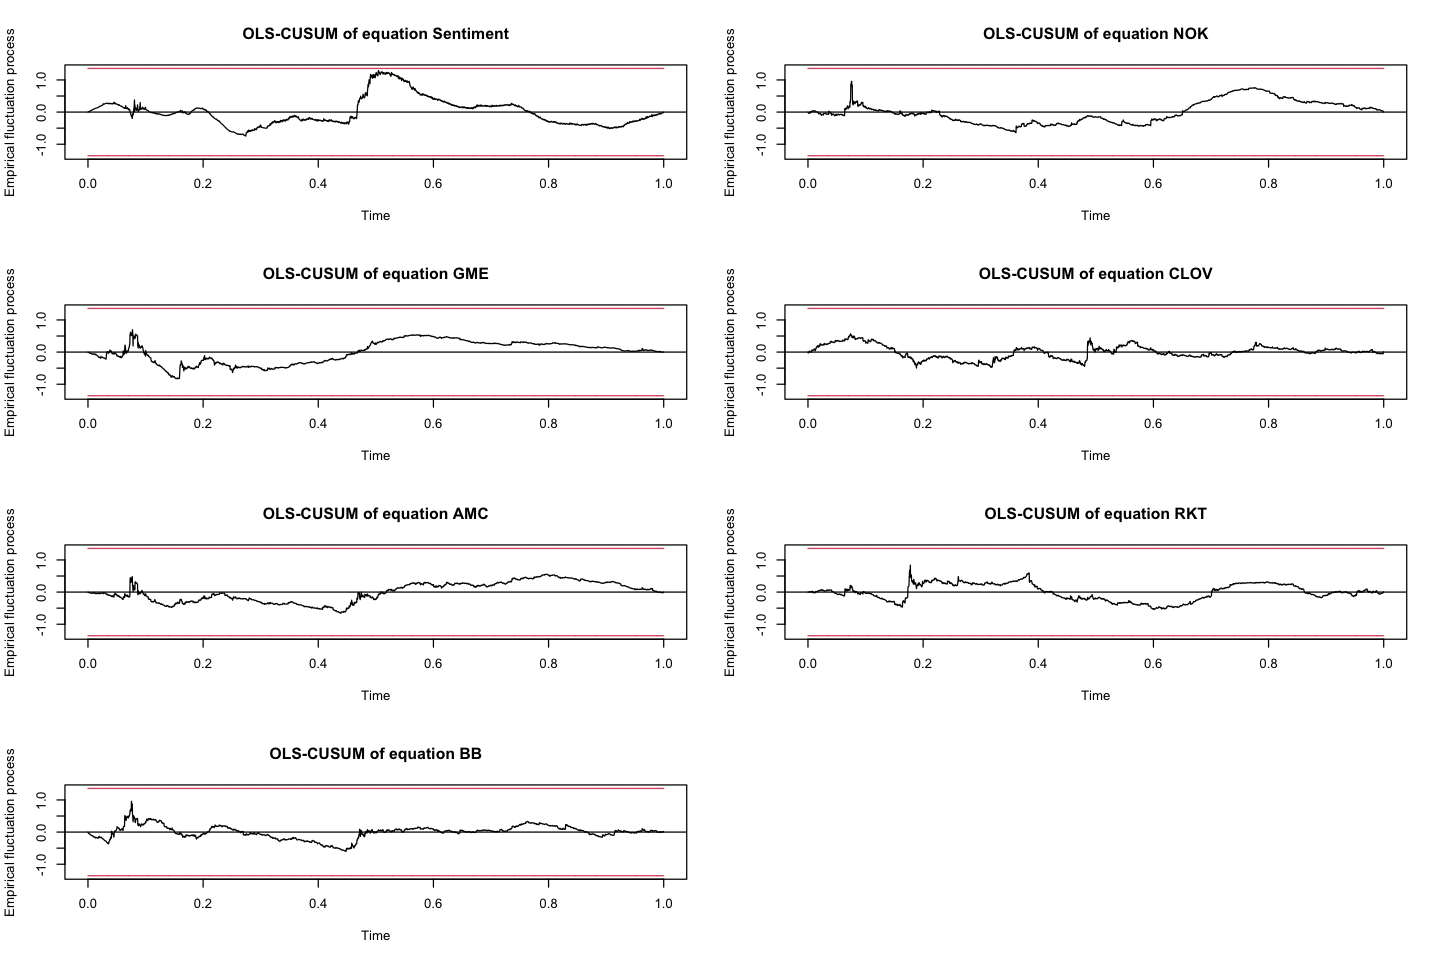

In [7]:
## Stability looks OK
print(1/roots(var_optim)[[1]])
print(1/roots(var_optim)[[2]])
plot(stability(var_optim))

## Additional lag VAR (representing cointegration)

In [8]:
var_coint <- VAR(data[-1], p = p + 1, type = "both")
summary(var_coint)


VAR Estimation Results:
Endogenous variables: Sentiment, GME, AMC, BB, NOK, CLOV, RKT 
Deterministic variables: both 
Sample size: 2833 
Log Likelihood: 35198.198 
Roots of the characteristic polynomial:
0.9951 0.9951 0.992 0.992 0.9885 0.9735 0.9047 0.465 0.465 0.3572 0.3348 0.3348 0.3303 0.3303 0.3056 0.268 0.239 0.1583 0.1583 0.1491 0.1491
Call:
VAR(y = data[-1], p = p + 1, type = "both")


Estimation results for equation Sentiment: 
Sentiment = Sentiment.l1 + GME.l1 + AMC.l1 + BB.l1 + NOK.l1 + CLOV.l1 + RKT.l1 + Sentiment.l2 + GME.l2 + AMC.l2 + BB.l2 + NOK.l2 + CLOV.l2 + RKT.l2 + Sentiment.l3 + GME.l3 + AMC.l3 + BB.l3 + NOK.l3 + CLOV.l3 + RKT.l3 + const + trend 

               Estimate Std. Error t value Pr(>|t|)    
Sentiment.l1  4.436e-01  1.869e-02  23.733  < 2e-16 ***
GME.l1        5.368e+00  2.778e+00   1.932  0.05343 .  
AMC.l1       -5.510e+00  3.662e+00  -1.505  0.13255    
BB.l1        -1.583e+01  6.842e+00  -2.314  0.02076 *  
NOK.l1       -2.857e-02  1.126e+01  -0.003 

## Testing significance of trends (using HAC errors)
1. Get HAC covariance matrix via `vcovHC` by running the `lm` model (again since vcovHC does not accept `lm` class from VAR??)
2. Run wald.test (t-test) using HAC covar matrix on trend variable

Trend is strongly significant only for the _Sentiment_ variable with p-value < $5\%$.

In [9]:
for (i in names(var_coint$varresult)){
    #exclude constant in lm since in the model there is const included
    var_eq = lm(y ~ -1 + ., data=var_coint$varresult[[i]]$model)
    HAC_VCOV = vcovHC(var_eq, type = "HC0")
    
    ## Check if correct lm model
    print(all.equal(var_eq$coef, var_coint$varresult[[i]]$coef, check.attributes = FALSE))
    w_HAC_test = wald.test(b = coef(var_eq), Sigma = HAC_VCOV, Terms = which(names(coef(var_eq))=="trend"))
    print(sprintf("Testing TREND significance in the VAR equation for %s", i))
    print(sprintf("Trend Coefficient: %e with p-value: %f", var_eq$coef['trend'], w_HAC_test$result[[1]][3]))
}

[1] TRUE
[1] "Testing TREND significance in the VAR equation for Sentiment"
[1] "Trend Coefficient: -8.555848e-04 with p-value: 0.045973"
[1] TRUE
[1] "Testing TREND significance in the VAR equation for GME"
[1] "Trend Coefficient: 2.326094e-06 with p-value: 0.426121"
[1] TRUE
[1] "Testing TREND significance in the VAR equation for AMC"
[1] "Trend Coefficient: 2.562237e-06 with p-value: 0.427923"
[1] TRUE
[1] "Testing TREND significance in the VAR equation for BB"
[1] "Trend Coefficient: 9.996512e-08 with p-value: 0.952467"
[1] TRUE
[1] "Testing TREND significance in the VAR equation for NOK"
[1] "Trend Coefficient: 1.006538e-06 with p-value: 0.320752"
[1] TRUE
[1] "Testing TREND significance in the VAR equation for CLOV"
[1] "Trend Coefficient: -2.286740e-06 with p-value: 0.102844"
[1] TRUE
[1] "Testing TREND significance in the VAR equation for RKT"
[1] "Trend Coefficient: -5.512623e-07 with p-value: 0.599585"


## Granger Causality tests (TY procedure): Wald-tests
1. Use the extended VAR model with p+k lags to control for cointegration relationship. _k_ denotes the order of integration which is 1 in this case
2. Wald test (F-test) the coefficients of lagged variables of the impulse variable in the response variable's VAR equation
3. Run for both directions for all variables

### Example $H_0: \text{GME does not Granger causes Sentiment}$ and $H_0: \text{Sentiment does not Granger cause GME}$
Null: In the VAR equation for sentiment GME lagged coefficients are zero (i.e. historical values of GME have effect on forecasting sentiment)

In [10]:
print("H0: GME does not GC Sentiment")
var_eq = var_coint$varresult[["Sentiment"]]
terms_vec = which(grepl("GME",rownames(data.frame(coef(var_eq))))==TRUE)

wald.test(b = coef(var_eq),
          Sigma = vcov(var_eq),
          Terms = terms_vec[-length(terms_vec)])

### Shows that H0 is rejected, i.e. GME Granger causes Sentiment

print("H0: Sentiment does not GC GME")

var_eq = var_coint$varresult[["GME"]]
terms_vec = which(grepl("Sentiment",rownames(data.frame(coef(var_eq))))==TRUE)

wald.test(b = coef(var_eq),
          Sigma = vcov(var_eq),
          Terms = terms_vec[-length(terms_vec)])

### Shows that H0 is rejected, i.e. Sentiment also Granger causes GME. Thus, we have biderectional relationship

[1] "H0: GME does not GC Sentiment"


Wald test:
----------

Chi-squared test:
X2 = 10.3, df = 2, P(> X2) = 0.0059

[1] "H0: Sentiment does not GC GME"


Wald test:
----------

Chi-squared test:
X2 = 44.0, df = 2, P(> X2) = 2.8e-10

## Comprehensive GC Matrix with p-values
Impulse variables in rows and response variables in columns, i.e. null hypothesis are constructed as 

$$H_0: \text{Row does not Granger cause Column}$$

In [11]:
gc_matrix = matrix(nrow = ncol(data[-1]), ncol = ncol(data[-1]))
rownames(gc_matrix) = colnames(data[-1])
colnames(gc_matrix) = colnames(data[-1])

for (i in colnames(data[-1])){
    for (j in colnames(data[-1])){
        lm_model = var_coint$varresult[[i]]
        if(i==j) next
        t_coef = which(grepl(j, rownames(data.frame(coef(lm_model))))==TRUE)
        pval = wald.test(b = coef(lm_model),
                         Sigma = vcov(lm_model),
                         Terms = t_coef[-length(t_coef)]
                        )$result[[1]][[3]]
#         print(sprintf("H0: %s does not GC %s",j,i))
#         print(pval)
        gc_matrix[j,i] = pval
#         gc_matrix[j,i]=round(pval,4)
    }
}
#INTERPRETATION
##H0: ROW does not GC COLUMN
##i.e. Second row First column: GME DOES NOT GC SENTIMENT p-value wald.test
round(gc_matrix,4)

,Sentiment,GME,AMC,BB,NOK,CLOV,RKT
Sentiment,NA,0.0000,0.0000,0.5334,0.1161,0.0157,0.6946
GME,0.0059,NA,0.0003,0.0000,0.4303,0.7768,0.4816
AMC,0.0161,0.0000,NA,0.0003,0.4614,0.4324,0.7841
BB,0.0509,0.0143,0.6642,NA,0.0000,0.4084,0.1293
NOK,0.7879,0.0000,0.0020,0.0099,NA,0.9696,0.0859
CLOV,0.0000,0.0019,0.2230,0.0403,0.7021,NA,0.0807
RKT,0.2476,0.7951,0.5569,0.2588,0.0222,0.5466,NA


### Alternative approach using `casaulity` function from `vars` package
??? methodology

In [12]:
for (i in names(var_coint$varresult)){
    print(causality(var_coint,i))
}

$Granger

	Granger causality H0: Sentiment do not Granger-cause GME AMC BB NOK
	CLOV RKT

data:  VAR object var_coint
F-Test = 8.931, df1 = 18, df2 = 19670, p-value < 2.2e-16


$Instant

	H0: No instantaneous causality between: Sentiment and GME AMC BB NOK
	CLOV RKT

data:  VAR object var_coint
Chi-squared = 46.376, df = 6, p-value = 2.491e-08


$Granger

	Granger causality H0: GME do not Granger-cause Sentiment AMC BB NOK
	CLOV RKT

data:  VAR object var_coint
F-Test = 5.5612, df1 = 18, df2 = 19670, p-value = 2.323e-13


$Instant

	H0: No instantaneous causality between: GME and Sentiment AMC BB NOK
	CLOV RKT

data:  VAR object var_coint
Chi-squared = 743.22, df = 6, p-value < 2.2e-16


$Granger

	Granger causality H0: AMC do not Granger-cause Sentiment GME BB NOK
	CLOV RKT

data:  VAR object var_coint
F-Test = 3.3327, df1 = 18, df2 = 19670, p-value = 2.106e-06


$Instant

	H0: No instantaneous causality between: AMC and Sentiment GME BB NOK
	CLOV RKT

data:  VAR object var_coint
Chi-

---
---
---
# VECM Model + Johanssen Cointegration Tests

Trend included due to _Sentiment_ variable
Johansen tests based on _trace_ statistic shows strong evidence (p-value $<1\%$) for 2 cointegration relationships.
However, _maximum eigenvalue_ statistic shows strong evidence for 1 cointegration.

We proceed with one cointegration and construct our VECM.

In [13]:
data <- data_level[c("X","Sentiment","GME","AMC","BB","NOK","CLOV","RKT")]
#optimal lag selected previously p = 2
johansen_trace <- ca.jo(data[-1], ecdet = "const", type = "trace", K = 3, spec = "transitory")
print(summary(johansen_trace))
vecm_model <- ca.jo(data[-1], ecdet = "const", type = "eigen", K = 3, spec = "transitory")
cajorls_model <- cajorls(vecm_model, r = 1)
summary(vecm_model) #weak evidence for 2 cointegrating relationships (5% level), strong evidence for 1 cointegration (1%)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  5.612633e-02  1.421886e-02  1.273664e-02  8.632542e-03  6.416513e-03
[6]  2.361968e-03  1.539603e-03 -2.036245e-18

Values of teststatistic and critical values of test:

           test  10pct   5pct   1pct
r <= 6 |   4.37   7.52   9.24  12.97
r <= 5 |  11.06  17.85  19.96  24.60
r <= 4 |  29.30  32.00  34.91  41.07
r <= 3 |  53.86  49.65  53.12  60.16
r <= 2 |  90.18  71.86  76.07  84.45
r <= 1 | 130.75  97.18 102.14 111.01
r = 0  | 294.39 126.58 131.70 143.09

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             Sentiment.l1      GME.l1      AMC.l1       BB.l1     NOK.l1
Sentiment.l1     1.000000     1.00000    1.000000      1.0000     1.0000
GME.l1         -12.991926  -246.13221 -293.760509   2451.1578   314.0252
AMC.l1           1.373129    50.90322  255.32161


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  5.612633e-02  1.421886e-02  1.273664e-02  8.632542e-03  6.416513e-03
[6]  2.361968e-03  1.539603e-03 -2.036245e-18

Values of teststatistic and critical values of test:

           test 10pct  5pct  1pct
r <= 6 |   4.37  7.52  9.24 12.97
r <= 5 |   6.70 13.75 15.67 20.20
r <= 4 |  18.24 19.77 22.00 26.81
r <= 3 |  24.56 25.56 28.14 33.24
r <= 2 |  36.31 31.66 34.40 39.79
r <= 1 |  40.57 37.45 40.30 46.82
r = 0  | 163.64 43.25 46.45 51.91

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             Sentiment.l1      GME.l1      AMC.l1       BB.l1     NOK.l1
Sentiment.l1     1.000000     1.00000    1.000000      1.0000     1.0000
GME.l1         -12.991926  -246.13221 -293.760509   2451.1578   314.0252
AMC.l1           1.373129    50.90322  255.321

## Summary of VECM model given by `cajorls`

In [14]:
summary(cajorls_model$rlm)

Response Sentiment.d :

Call:
lm(formula = Sentiment.d ~ ect1 + Sentiment.dl1 + GME.dl1 + AMC.dl1 + 
    BB.dl1 + NOK.dl1 + CLOV.dl1 + RKT.dl1 + Sentiment.dl2 + GME.dl2 + 
    AMC.dl2 + BB.dl2 + NOK.dl2 + CLOV.dl2 + RKT.dl2 - 1, data = data.mat)

Residuals:
    Min      1Q  Median      3Q     Max 
-96.559  -2.105  -0.363   1.638  51.406 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
ect1           -0.14937    0.01311 -11.396  < 2e-16 ***
Sentiment.dl1  -0.40373    0.01995 -20.242  < 2e-16 ***
GME.dl1         3.25751    2.78598   1.169  0.24240    
AMC.dl1        -4.92815    3.65066  -1.350  0.17715    
BB.dl1        -16.14989    6.81666  -2.369  0.01789 *  
NOK.dl1         0.15774   11.22208   0.014  0.98879    
CLOV.dl1       13.84822    5.43788   2.547  0.01093 *  
RKT.dl1        -2.29634    8.03898  -0.286  0.77517    
Sentiment.dl2  -0.11842    0.01884  -6.285 3.78e-10 ***
GME.dl2         5.35209    2.77093   1.932  0.05352 .  
AMC.dl2         9.67663    3.

## GC Test Short-run Dynamics in VECM

Wald tests on the lagged impulse variables (analogy of TY procedure above excluding the ECT vectors).

In [15]:
gc_matrix_sr = matrix(nrow = ncol(data[-1]), ncol = ncol(data[-1]))
rownames(gc_matrix_sr) = colnames(data[-1])
colnames(gc_matrix_sr) = colnames(data[-1])

for (i in colnames(data[-1])){
    for (j in colnames(data[-1])){
        lm_model = summary(cajorls_model$rlm)[[paste0("Response ",i,".d")]]
        if(i==j) next
        t_coef = which(grepl(j, rownames(data.frame(coef(lm_model)[,1])))==TRUE)
        pval = wald.test(b = coef(lm_model)[,1],
                         Sigma = vcov(lm_model),
                         Terms = t_coef
                        )$result[[1]][[3]]
#         print(sprintf("H0: %s does not GC %s",j,i))
#         print(pval)
        gc_matrix_sr[j,i] = pval
#         gc_matrix[j,i]=round(pval,4)
    }
}
#INTERPRETATION
##H0: ROW does not GC COLUMN
##i.e. Second row First column: GME DOES NOT GC SENTIMENT p-value wald.test
round(gc_matrix_sr,4)

,Sentiment,GME,AMC,BB,NOK,CLOV,RKT
Sentiment,NA,0.0000,0.0000,0.3886,0.1679,0.0005,0.9426
GME,0.0948,NA,0.0005,0.0000,0.4489,0.6814,0.4728
AMC,0.0127,0.0000,NA,0.0006,0.4279,0.4564,0.7765
BB,0.0430,0.0146,0.6821,NA,0.0000,0.3668,0.1329
NOK,0.7751,0.0000,0.0022,0.0079,NA,0.9789,0.0472
CLOV,0.0000,0.0017,0.3131,0.0381,0.7356,NA,0.0773
RKT,0.4402,0.8142,0.4991,0.1797,0.0176,0.5765,NA


## GC Test Long-Run Dynamics in VECM (given by ECT, i.e. betas???)

In [16]:
for (i in 1:length(summary(cajorls_model$rlm))){
    print(sprintf("Cointegrating vector ECT for %s : %e.", colnames(data[-1])[i], coef(summary(cajorls_model$rlm)[[i]])[1,1]))
    print(sprintf("PVALUE: %0.4f",coef(summary(cajorls_model$rlm)[[i]])[1,4]))
}
cajorls_model$beta

[1] "Cointegrating vector ECT for Sentiment : -1.493712e-01."
[1] "PVALUE: 0.0000"
[1] "Cointegrating vector ECT for GME : -9.992330e-05."
[1] "PVALUE: 0.3591"
[1] "Cointegrating vector ECT for AMC : 2.283396e-04."
[1] "PVALUE: 0.0105"
[1] "Cointegrating vector ECT for BB : 3.052578e-05."
[1] "PVALUE: 0.4930"
[1] "Cointegrating vector ECT for NOK : -1.791963e-05."
[1] "PVALUE: 0.4708"
[1] "Cointegrating vector ECT for CLOV : 1.534322e-04."
[1] "PVALUE: 0.0011"
[1] "Cointegrating vector ECT for RKT : 4.786957e-05."
[1] "PVALUE: 0.1309"


,ect1
Sentiment.l1,1.000000
GME.l1,-12.991926
AMC.l1,1.373129
BB.l1,1.128556
NOK.l1,7.113603
CLOV.l1,-29.904862
RKT.l1,12.385593
constant,69.341760


In [17]:
# extract B
B_0 <- cajorls_model$beta
# Set one element to zero
B_0[2] <- 0
B_0
#test
blrtest(vecm_model, H=B_0, r=1)

,ect1
Sentiment.l1,1.000000
GME.l1,0.000000
AMC.l1,1.373129
BB.l1,1.128556
NOK.l1,7.113603
CLOV.l1,-29.904862
RKT.l1,12.385593
constant,69.341760



##################################################### 
# Johansen-Procedure Unit Root / Cointegration Test # 
##################################################### 

The value of the test statistic is: 158.8774 


## Diagnostics


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vec2var(vecm_model, r = 1)
Chi-squared = 3878.2, df = 644, p-value < 2.2e-16


[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for Sentiment.d p-value: 0.0000"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for GME.d p-value: 0.0000"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for AMC.d p-value: 0.0000"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for BB.d p-value: 0.0000"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for NOK.d p-value: 0.0000"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for CLOV.d p-value: 0.0000"

[1] "#################

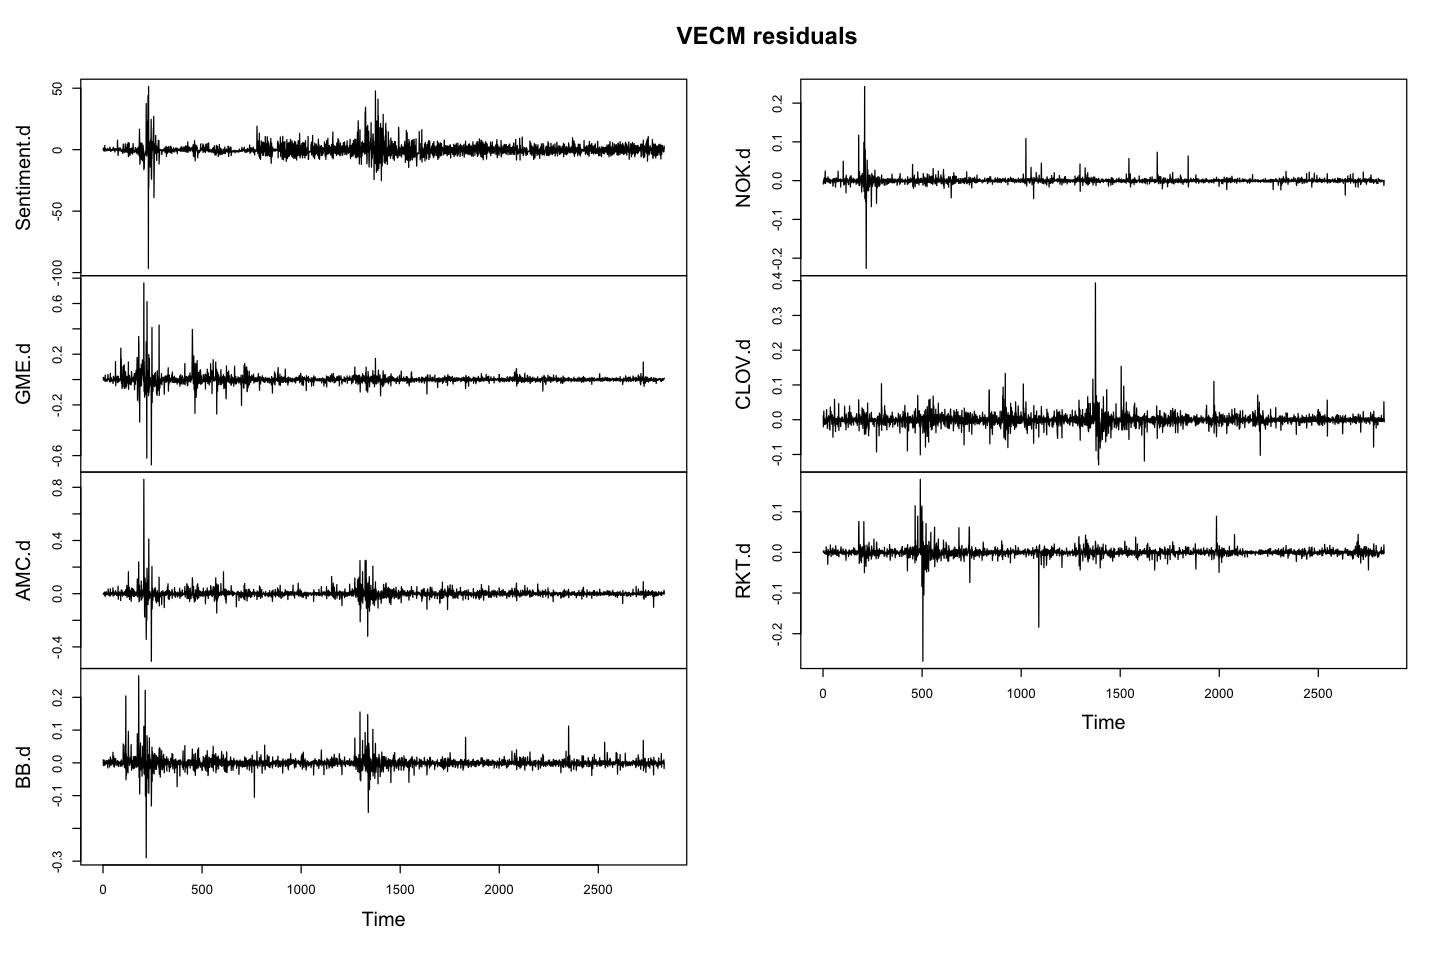

In [18]:
serial.test(vec2var(vecm_model, r = 1))$serial
plot.ts(cajorls_model$rlm$residuals, main = "VECM residuals")
# checkresiduals(cajorls_model$rlm$residuals[,1])
for (i in colnames(cajorls_model$rlm$residuals)){
    adf = ur.df(cajorls_model$rlm$residuals[, i], selectlags = "BIC")
    print("##############################################################################")
    print(sprintf("Augmented Dickey-Fuller Test Unit Root test for %s p-value: %.4f", i,
                  adf@testreg$coef[1,4]))
    
    cat("\n")
}

In [19]:
summary(cajorls_model$rlm)[[1]]


Call:
lm(formula = Sentiment.d ~ ect1 + Sentiment.dl1 + GME.dl1 + AMC.dl1 + 
    BB.dl1 + NOK.dl1 + CLOV.dl1 + RKT.dl1 + Sentiment.dl2 + GME.dl2 + 
    AMC.dl2 + BB.dl2 + NOK.dl2 + CLOV.dl2 + RKT.dl2 - 1, data = data.mat)

Residuals:
    Min      1Q  Median      3Q     Max 
-96.559  -2.105  -0.363   1.638  51.406 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
ect1           -0.14937    0.01311 -11.396  < 2e-16 ***
Sentiment.dl1  -0.40373    0.01995 -20.242  < 2e-16 ***
GME.dl1         3.25751    2.78598   1.169  0.24240    
AMC.dl1        -4.92815    3.65066  -1.350  0.17715    
BB.dl1        -16.14989    6.81666  -2.369  0.01789 *  
NOK.dl1         0.15774   11.22208   0.014  0.98879    
CLOV.dl1       13.84822    5.43788   2.547  0.01093 *  
RKT.dl1        -2.29634    8.03898  -0.286  0.77517    
Sentiment.dl2  -0.11842    0.01884  -6.285 3.78e-10 ***
GME.dl2         5.35209    2.77093   1.932  0.05352 .  
AMC.dl2         9.67663    3.63193   2.664  0.00776 

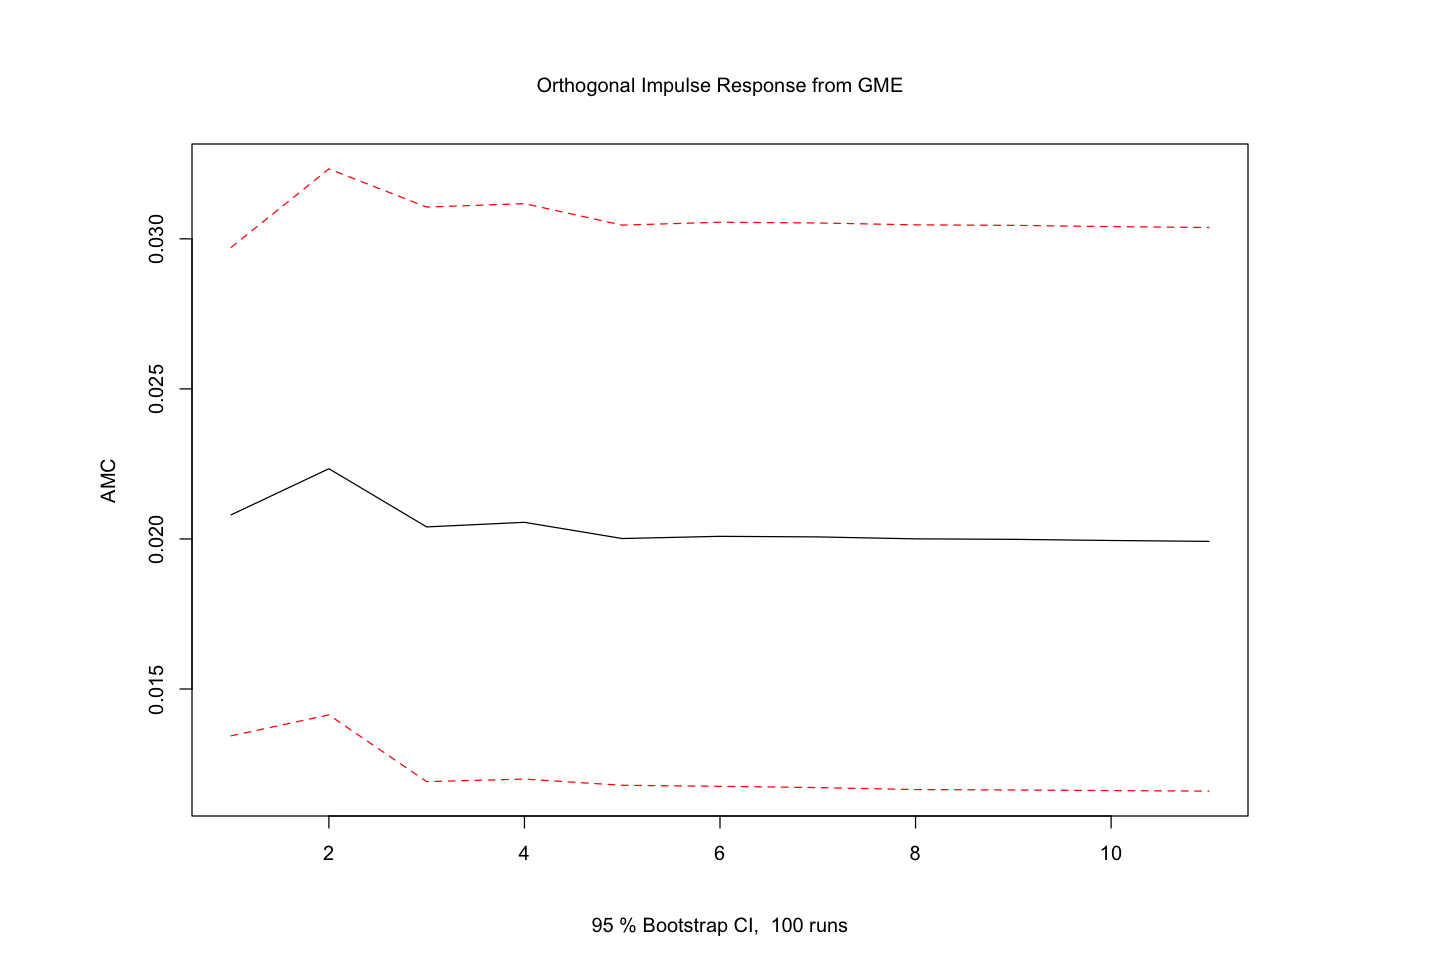

In [20]:
### Better IRF plots are offerred in python
plot(irf(vec2var(vecm_model, r = 1), impulse = "GME", response = "AMC", runs = 100, ortho = TRUE))

---
---
# tsdyn Package VECM
requires lag of differenced y, i.e. the optimal amount of lags input in `ca.jo` - 1

In [21]:
tsdyn_vecm <- VECM(data[-1], lag = 2, r = 1, estim = "ML", LRinclude = "trend")
tsdyn_coefs <- summary(tsdyn_vecm)$coefMat
tsdyn_coefs[grep("ECT",rownames(tsdyn_coefs)),]
coefB(tsdyn_vecm)
##Check if results equal to cajorls model
all.equal(coefB(tsdyn_vecm), cajorls_model$beta, check.attributes = FALSE)

,Estimate,Std. Error,t value,Pr(>|t|)
Sentiment:ECT,-1.528159e-01,1.320391e-02,-11.5735353,2.688610e-30
GME:ECT,-9.101588e-05,1.098053e-04,-0.8288839,4.072403e-01
AMC:ECT,2.391356e-04,8.985969e-05,2.6612111,7.830209e-03
BB:ECT,3.157628e-05,4.487711e-05,0.7036165,4.817298e-01
NOK:ECT,-1.426408e-05,2.504170e-05,-0.5696132,5.689855e-01
CLOV:ECT,1.447422e-04,4.750647e-05,3.0467884,2.334453e-03
RKT:ECT,4.577177e-05,3.193611e-05,1.4332295,1.519032e-01


,r1
Sentiment,1.000000000
GME,-12.464852948
AMC,-0.154561881
BB,1.841367499
NOK,3.509886033
CLOV,-27.254163507
RKT,15.664707068
trend,0.002927887


[1] "Mean relative difference: 1.340723"

---
---
---

# News Sentiment VECM fitting

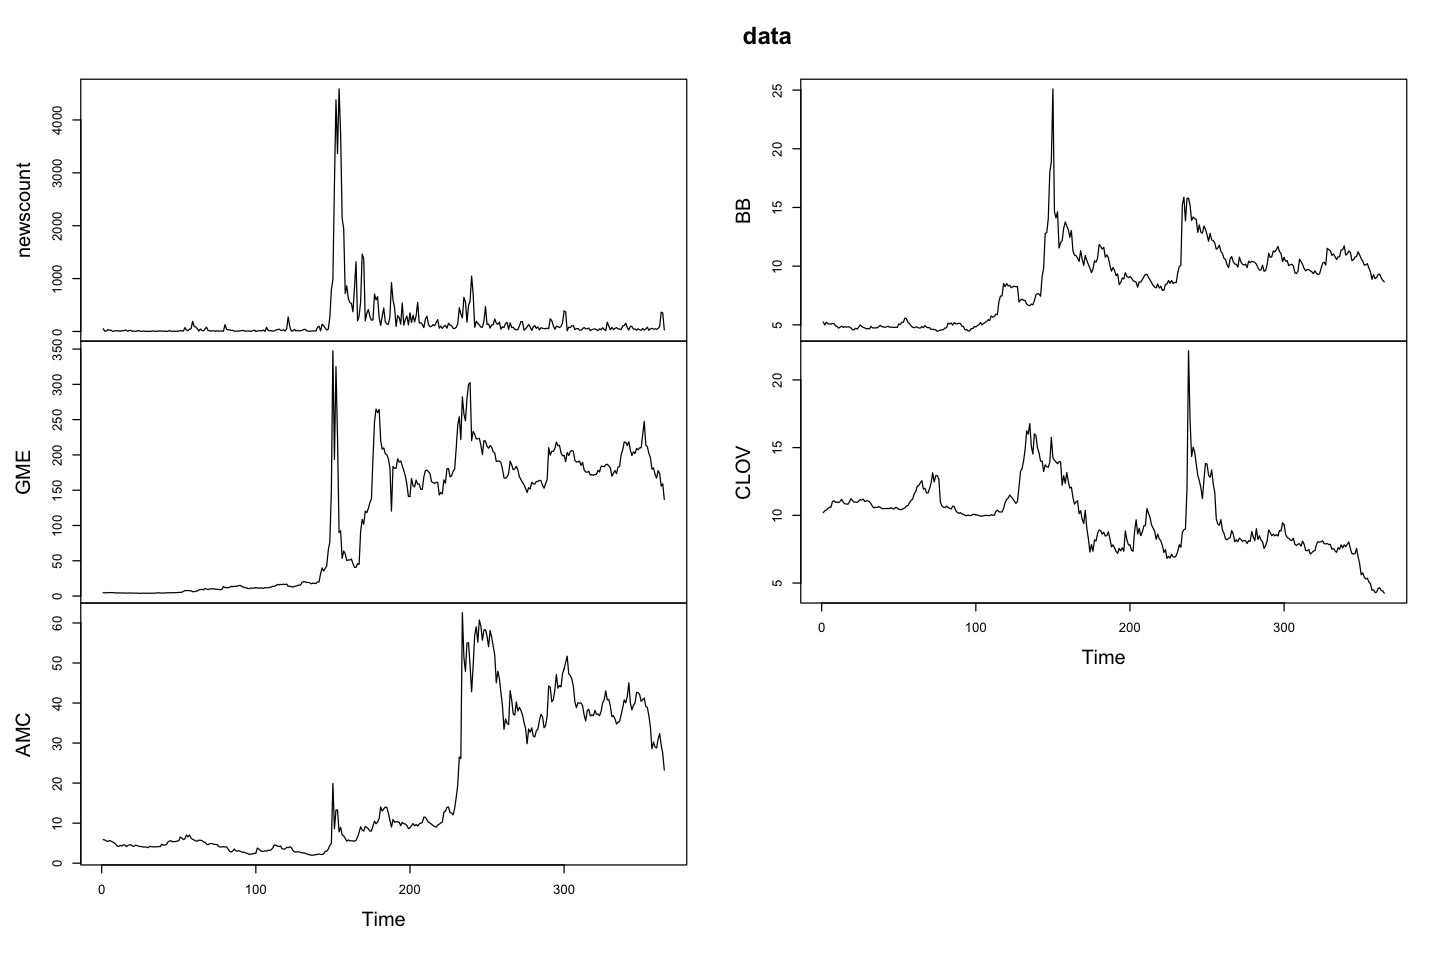

In [22]:
data_news = read.csv("newsxgme_data.csv")
data = data_news[,c("newscount","GME","AMC","BB","CLOV")]
plot.ts(data)

In [23]:
for (i in colnames(data)){
    adf = ur.df(data[, i], selectlags = "BIC")
    print("##############################################################################")
    print(sprintf("Augmented Dickey-Fuller Test Unit Root test for %s p-value: %.4f", i,
                  adf@testreg$coef[1,4]))
    adf = ur.df(data[, i], type = "trend", selectlags = "BIC")
    print(sprintf("incl. trend for %s p-value: %.4f", i,
                  adf@testreg$coef[1,4]))
    cat("\n")
}
print("KPSS test for newscount")
summary(ur.kpss(data$newscount, type = "tau"))

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for newscount p-value: 0.0000"
[1] "incl. trend for newscount p-value: 0.3313"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for GME p-value: 0.3642"
[1] "incl. trend for GME p-value: 0.8757"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for AMC p-value: 0.5153"
[1] "incl. trend for AMC p-value: 0.9119"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for BB p-value: 0.5926"
[1] "incl. trend for BB p-value: 0.0139"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for CLOV p-value: 0.3153"
[1] "incl. trend for C


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 5 lags. 

Value of test-statistic is: 0.3141 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


In [24]:
varselect <- VARselect(data, lag = 12, type = "both")
p <- as.numeric(varselect$selection[3]) #optimal number of lags
print(p)
var_optim <- VAR(data, p = p, type = "both")
# summary(var_optim)

vecm_model <- ca.jo(data, ecdet = "trend", type = "eigen", K = p, spec = "transitory")
cajorls_model <- cajorls(vecm_model, r = 1)
summary(vecm_model)
# summary(cajorls_model$rlm) 
#one cointegration relationship but newscount is shown possibly stationary as per ADF test at 5%

[1] 3



###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend in cointegration 

Eigenvalues (lambda):
[1]  1.914904e-01  7.157018e-02  4.654436e-02  1.861728e-02  9.926463e-03
[6] -2.281999e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 4 |  3.61 10.49 12.25 16.26
r <= 3 |  6.80 16.85 18.96 23.65
r <= 2 | 17.25 23.11 25.54 30.34
r <= 1 | 26.88 29.12 31.46 36.65
r = 0  | 76.95 34.75 37.52 42.36

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             newscount.l1      GME.l1     AMC.l1      BB.l1     CLOV.l1
newscount.l1     1.000000    1.000000    1.00000    1.00000    1.000000
GME.l1           3.614210  -15.520348  -46.09291  -35.55384   -8.912212
AMC.l1           8.293445   63.491604   25.43586  129.60594 -134.401822
BB.l1         -242.839593  282.444252 -345.72552 1307.00655  409.907398
CLOV.l1         79.8884

In [25]:
gc_matrix_news_sr = matrix(nrow = ncol(data), ncol = ncol(data))
rownames(gc_matrix_news_sr) = colnames(data)
colnames(gc_matrix_news_sr) = colnames(data)

for (i in colnames(data)){
    for (j in colnames(data)){
        lm_model = summary(cajorls_model$rlm)[[paste0("Response ",i,".d")]]
        if(i==j) next
        t_coef = which(grepl(j, rownames(data.frame(coef(lm_model)[,1])))==TRUE)
        pval = wald.test(b = coef(lm_model)[,1],
                         Sigma = vcov(lm_model),
                         Terms = t_coef
                        )$result[[1]][[3]]
#         print(sprintf("H0: %s does not GC %s",j,i))
#         print(pval)
        gc_matrix_news_sr[j,i] = pval
#         gc_matrix[j,i]=round(pval,4)
    }
}
#INTERPRETATION
##H0: ROW does not GC COLUMN
##i.e. Second row First column: GME DOES NOT GC SENTIMENT p-value wald.test

round(gc_matrix_news_sr,4)
cajorls_model$beta

,newscount,GME,AMC,BB,CLOV
newscount,NA,0.0010,0.0895,0.8017,0.6380
GME,0.0000,NA,0.0946,0.0000,0.0037
AMC,0.0001,0.3316,NA,0.3691,0.1613
BB,0.0108,0.0000,0.0400,NA,0.0091
CLOV,0.0083,0.0000,0.0232,0.0465,NA


,ect1
newscount.l1,1.000000
GME.l1,3.614210
AMC.l1,8.293445
BB.l1,-242.839593
CLOV.l1,79.888460
trend.l1,2.251290


In [26]:
varselect <- VARselect(data, lag = 12, type = "both")
p <- as.numeric(varselect$selection[3]) #optimal number of lags
var_optim <- VAR(data, p = p, type = "both")
# summary(var_optim)

vecm_model <- ca.jo(data, ecdet = "none", type = "eigen", K = p, spec = "transitory")
cajorls_model <- cajorls(vecm_model, r = 1)

gc_matrix_news_sr = matrix(nrow = ncol(data), ncol = ncol(data))
rownames(gc_matrix_news_sr) = colnames(data)
colnames(gc_matrix_news_sr) = colnames(data)

for (i in colnames(data)){
    for (j in colnames(data)){
        lm_model = summary(cajorls_model$rlm)[[paste0("Response ",i,".d")]]
        if(i==j) next
        t_coef = which(grepl(j, rownames(data.frame(coef(lm_model)[,1])))==TRUE)
        pval = wald.test(b = coef(lm_model)[,1],
                         Sigma = vcov(lm_model),
                         Terms = t_coef
                        )$result[[1]][[3]]
#         print(sprintf("H0: %s does not GC %s",j,i))
#         print(pval)
        gc_matrix_news_sr[j,i] = pval
#         gc_matrix[j,i]=round(pval,4)
    }
}
#INTERPRETATION
##H0: ROW does not GC COLUMN
##i.e. Second row First column: GME DOES NOT GC SENTIMENT p-value wald.test
round(gc_matrix_news_sr,4)
cajorls_model$beta

,newscount,GME,AMC,BB,CLOV
newscount,NA,0.0008,0.0860,0.6881,0.7772
GME,0.0000,NA,0.0992,0.0000,0.0072
AMC,0.0001,0.4600,NA,0.4132,0.1700
BB,0.0195,0.0000,0.0406,NA,0.0219
CLOV,0.0099,0.0000,0.0206,0.0498,NA


,ect1
newscount.l1,1.000000
GME.l1,3.906875
AMC.l1,13.277339
BB.l1,-214.113735
CLOV.l1,39.910484


# Testing unit root of the ECT terms/residuals

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for newscount p-value: 0.0000"
[1] "incl. drift for newscount p-value: 0.0661"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for GME p-value: 0.0000"
[1] "incl. drift for GME p-value: 0.0728"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for AMC p-value: 0.0000"
[1] "incl. drift for AMC p-value: 0.2007"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for BB p-value: 0.0000"
[1] "incl. drift for BB p-value: 0.0206"

[1] "##############################################################################"
[1] "Augmented Dickey-Fuller Test Unit Root test for CLOV p-value: 0.0000"
[1] "incl. drift for C

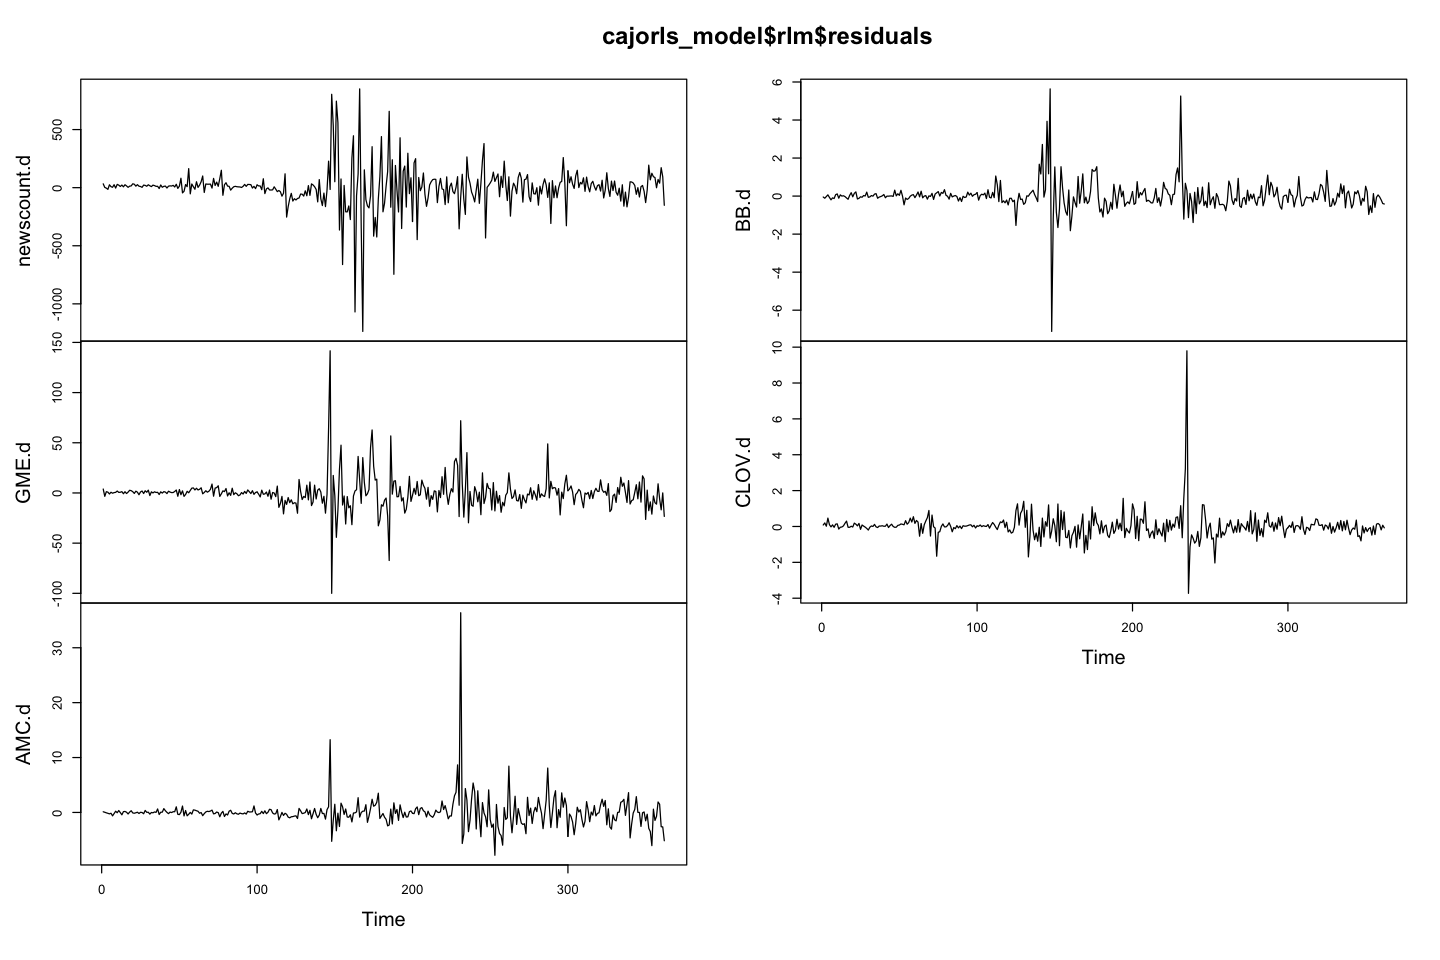

In [27]:
plot.ts(cajorls_model$rlm$residuals)
for (i in colnames(data)){
    adf = ur.df(cajorls_model$rlm$residuals[, paste0(i,".d")], selectlags = "BIC")
    print("##############################################################################")
    print(sprintf("Augmented Dickey-Fuller Test Unit Root test for %s p-value: %.4f", i,
                  adf@testreg$coef[1,4]))
    adf = ur.df(data[, i], type = "drift", selectlags = "BIC")
    print(sprintf("incl. drift for %s p-value: %.4f", i,
                  adf@testreg$coef[1,4]))
    cat("\n")
}

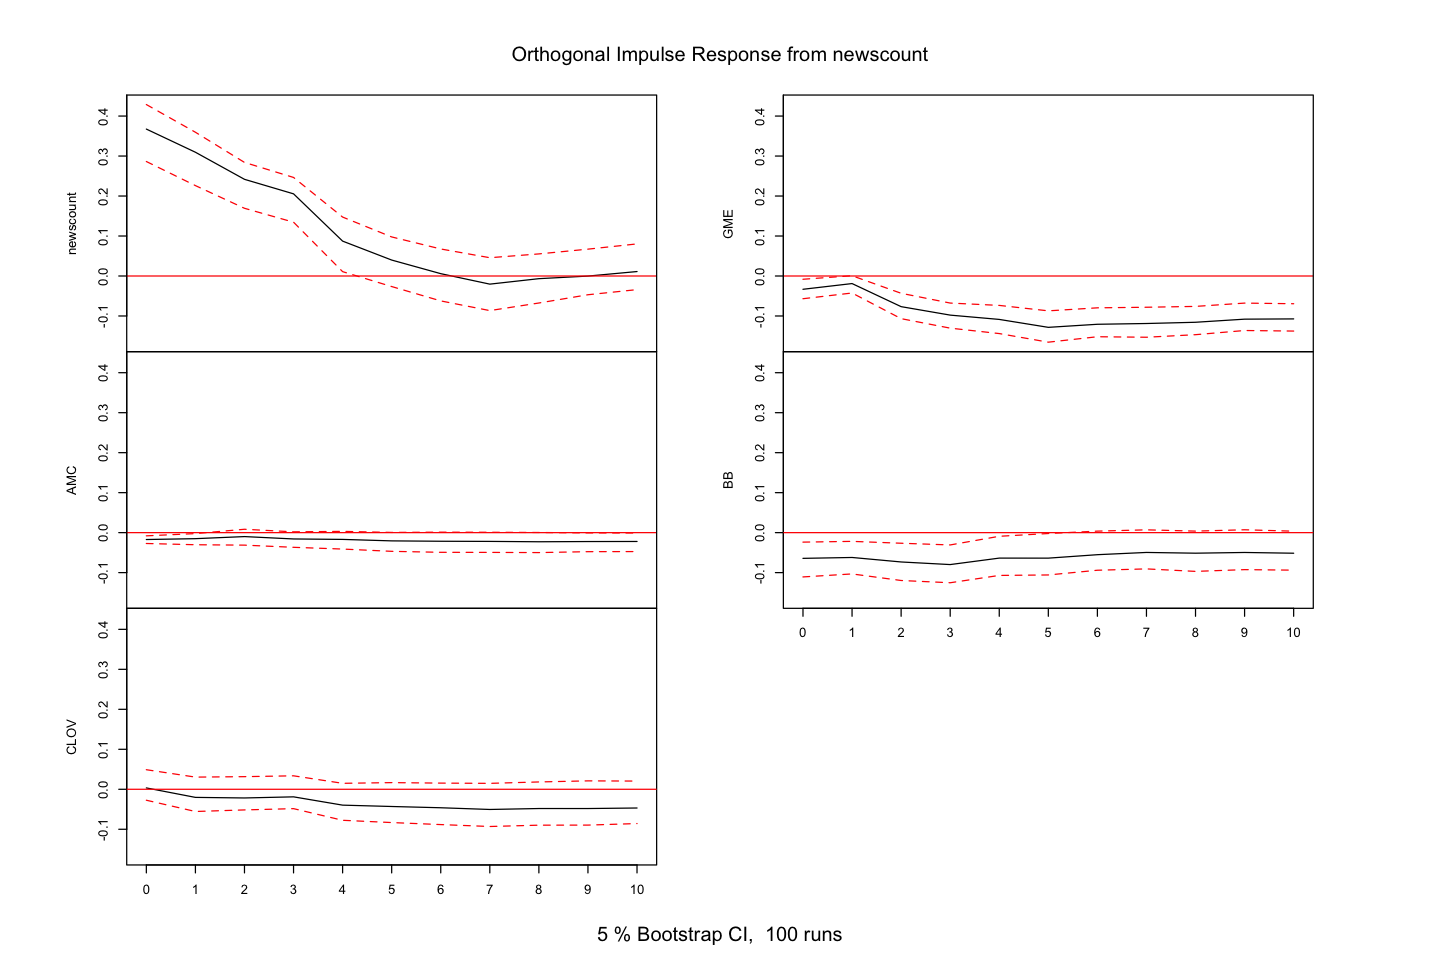

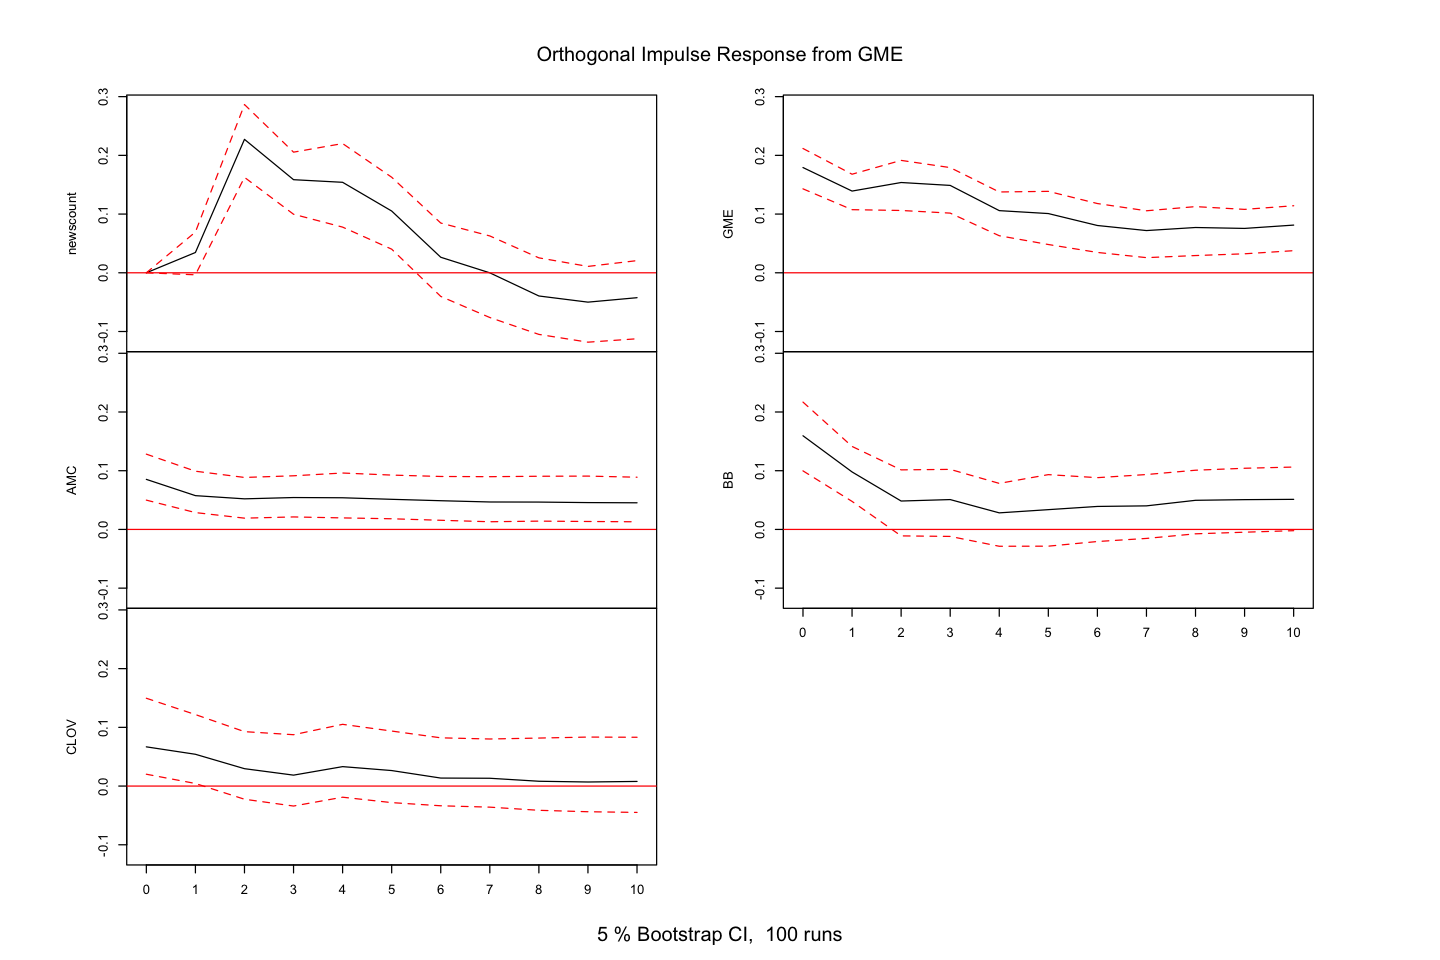

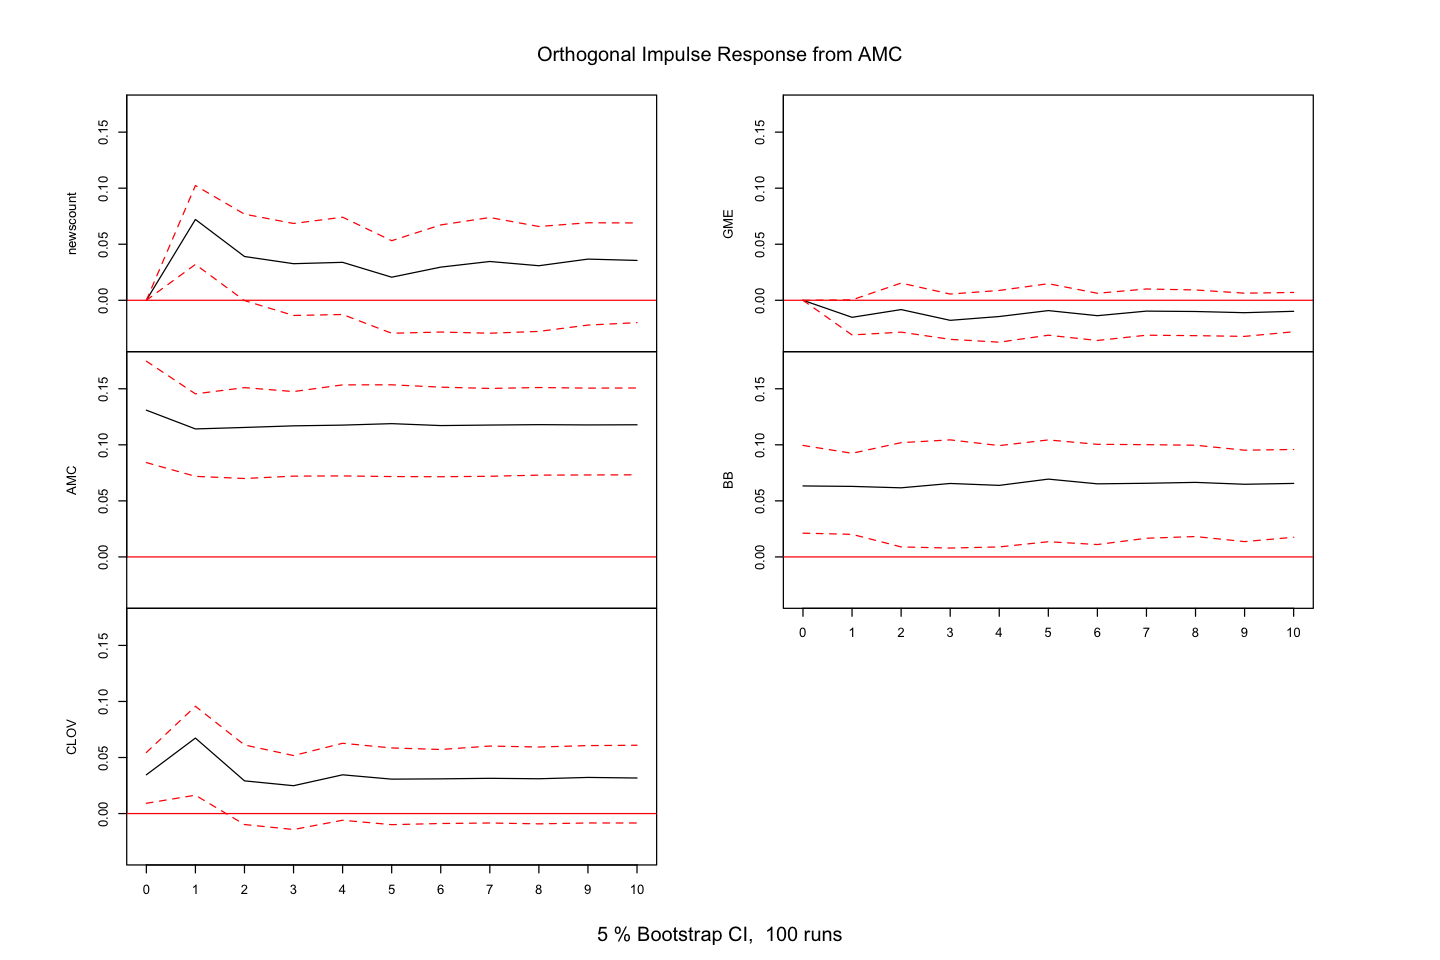

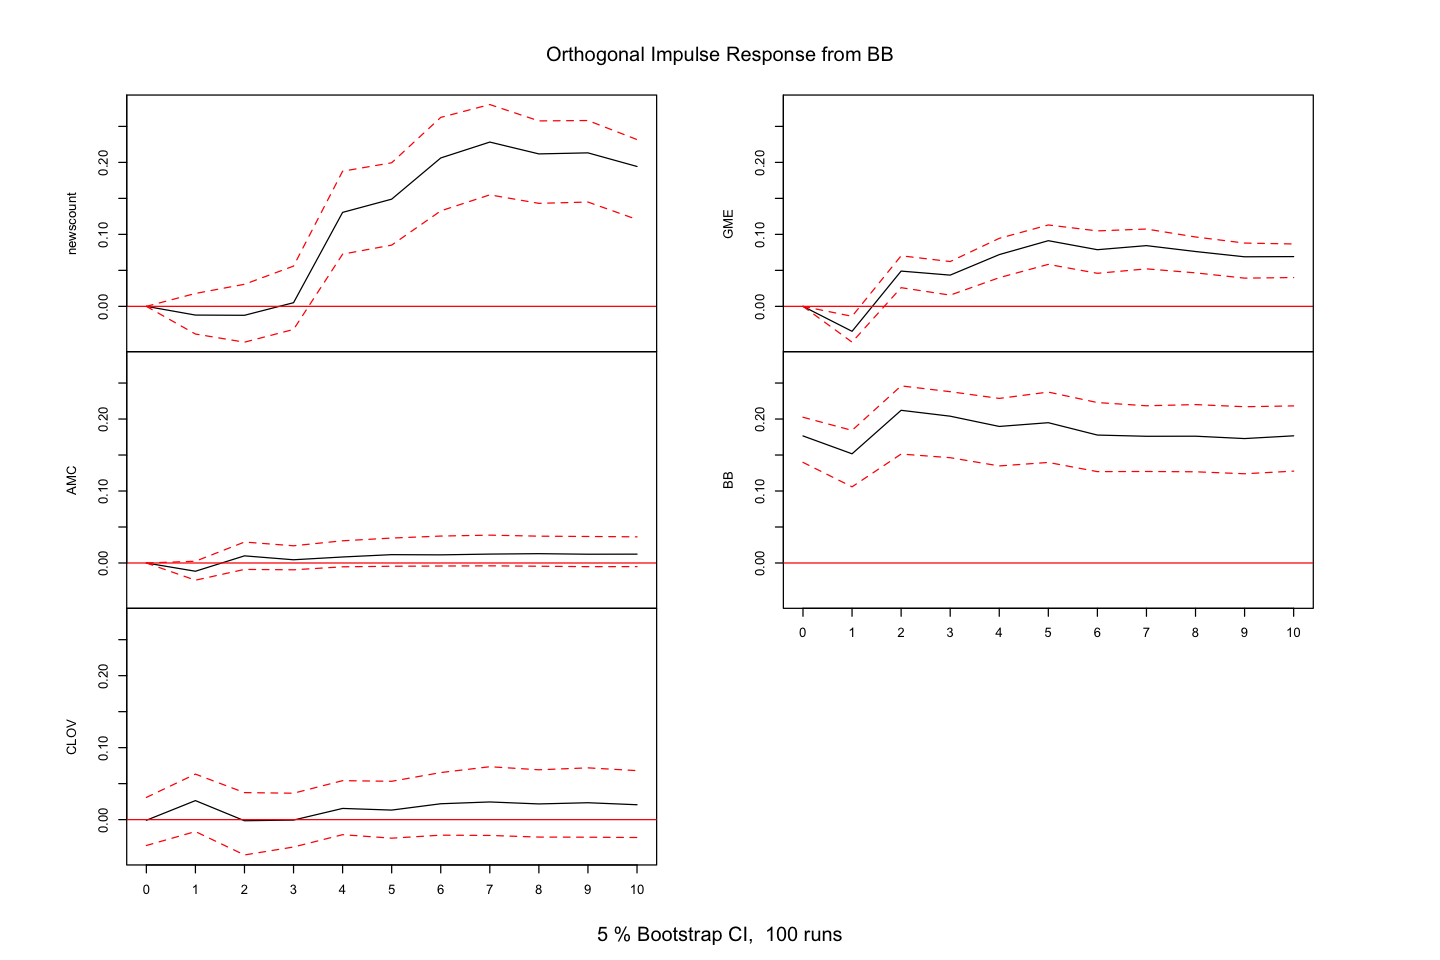

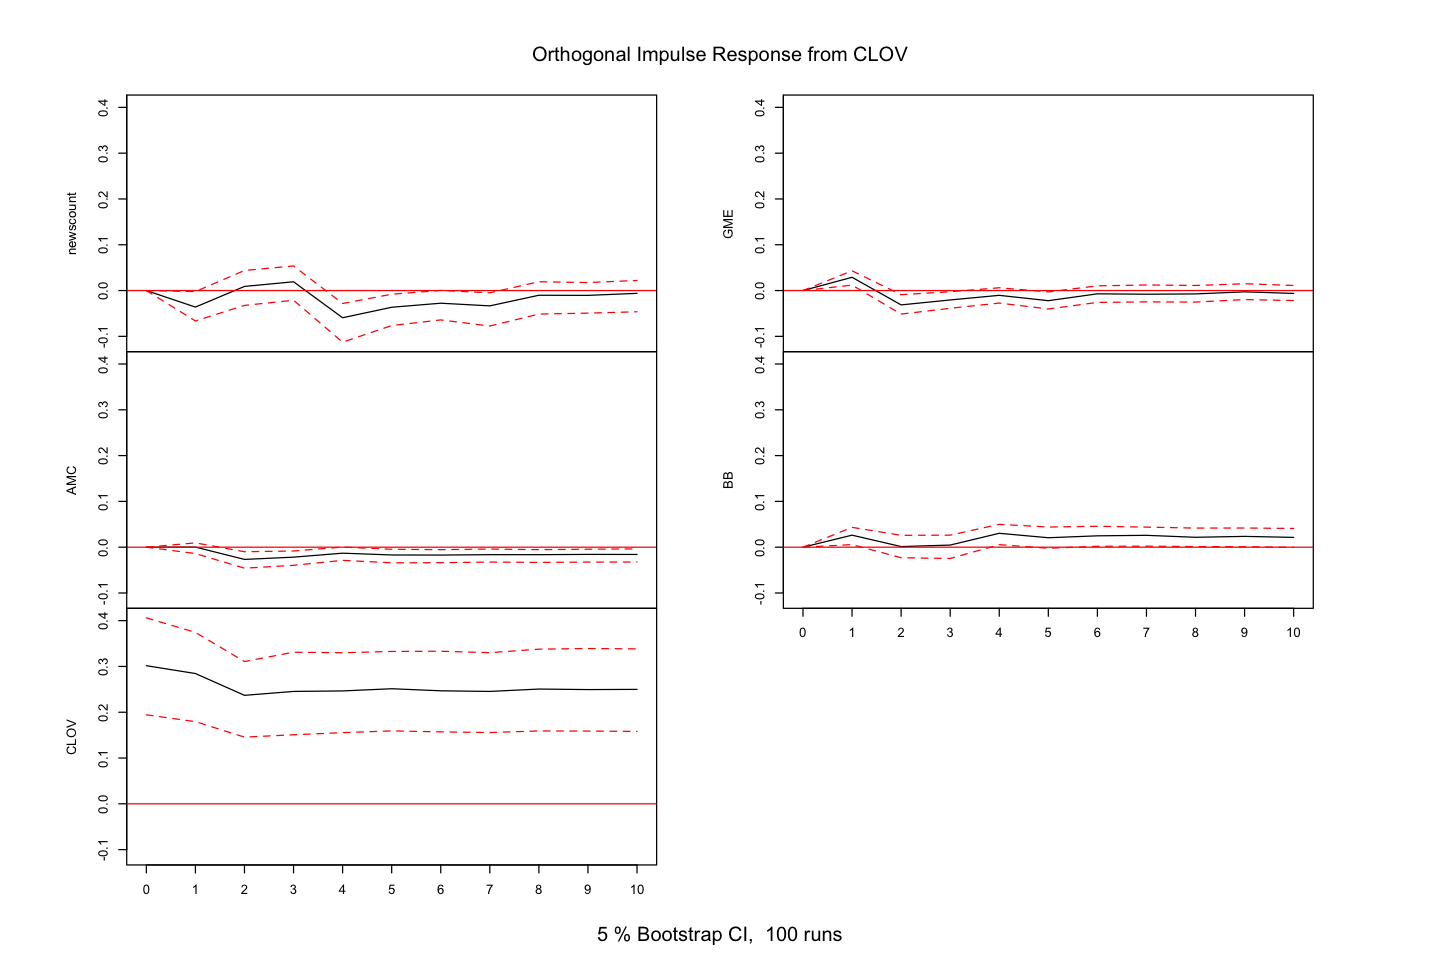

In [28]:
plot(irf(VECM(sapply(data, function(x) (x-mean(x))/sd(x)), lag = 2, r = 1, estim = "ML", include = "trend")))

----
----
----